In [1]:
!pip install python-binance

     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 288 kB 23.5 MB/s 
     |████████████████████████████████| 103 kB 36.1 MB/s 
     |████████████████████████████████| 1.1 MB 45.1 MB/s 
     |████████████████████████████████| 271 kB 53.7 MB/s 
     |████████████████████████████████| 160 kB 72.9 MB/s 
     |████████████████████████████████| 192 kB 69.2 MB/s 


In [2]:
%matplotlib inline
from binance import Client
import requests        
import json            
import pandas as pd    
import numpy as np     
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import figure
import datetime as dt
from datetime import datetime, date, time, timezone
import time as time_

In [3]:
def getAllSymbols(): 
  symbols = json.loads(requests.get("https://api.binance.com/api/v3/exchangeInfo").text)
  btcpairs = [symbol['symbol'] for symbol in symbols['symbols'] if symbol['quoteAsset'] == 'BTC' and symbol['status'] == 'TRADING']  
  ethpairs = [symbol['symbol'] for symbol in symbols['symbols'] if symbol['quoteAsset'] == 'ETH' and symbol['status'] == 'TRADING' and symbol['baseAsset'] not in btcpairs]
  return btcpairs,ethpairs

In [4]:
def marketCap():
  cgeckoReq = 'https://api.coingecko.com/api/v3/coins/markets?vs_currency=USD&order=market_cap_desc&per_page=50&page=1&sparkline=false'
  top50mktcap = json.loads(requests.get(cgeckoReq).text)
  coinCap = {}
  for x in top50mktcap:
    idx = x['symbol']
    coinCap[idx] = x['market_cap']

  return coinCap

In [5]:
def get_bars(startTime, endTime, symbol, interval = '1m'):
    root_url = 'https://api.binance.com/api/v3/klines'
    url = root_url + '?symbol=' + symbol + '&interval=' + interval + '&startTime=' + startTime + '&endTime=' + endTime #Create URL
    data = json.loads(requests.get(url).text)

    df = pd.DataFrame(data)
    df.columns = ['open_time', 'o', 'h', 'l', 'c', 'v', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'] #Sort data received
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
    return df

In [6]:
def millisTime(year,month,day,hour,minute,second):
  d = date(year,month,day)
  t = time(hour,minute,second)
  res = datetime.combine(d,t)
  return res.timestamp() * 1000

In [7]:
def getMktData(s,e, symbols):
  start = str(int(s))
  end = str(int(e)) #str(int(round(time_.time() * 1000)))
  
  btcusdt = get_bars(start,end, 'BTCUSDT')
  price_data = pd.DataFrame()
  missing = []
  for symbol in symbols:
    try:
      data = get_bars(start,end, symbol.upper()+'BTC')
      price_data.reset_index()
      price_data[symbol] = data['c'].astype('float') * btcusdt['c'].astype('float')
    except:
      missing.append(symbol)
      
  return price_data

In [8]:
def saveData(data):
  today = date.today() 
  fname = today.strftime("%d%m%Y")
  pathName = r'' 
  data.to_csv(pathName+fname+'DATA.csv')
  print('saved')
  return pathName+fname

In [9]:
def get30Min(startYear, startMonth, startDay, months):
  alldata = pd.DataFrame()
  coinlist = marketCap().keys()

  for x in range(0,months):
    start = millisTime(startYear,startMonth+x,startDay,0,0,0)
    end = millisTime(startYear,startMonth+(x+1),startDay,0,0,0)
    data = getMktData(start,end,coinlist)
    alldata = pd.concat([data,alldata],axis=0)
  return alldata

In [10]:
data = get30Min(2021,1,1,11);

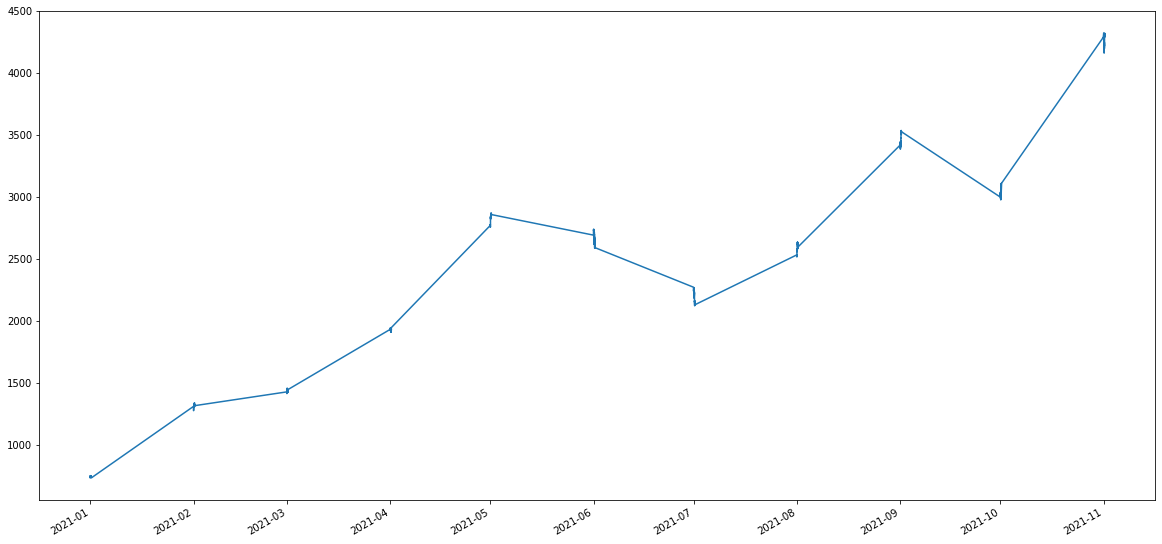

In [11]:
plt.figure(figsize=(20,10))
data['eth'].plot()

In [12]:
class CryptoData:
  def __init__(self):
    self.count = 0;

  def marketCap(self):
    cgeckoReq = 'https://api.coingecko.com/api/v3/coins/markets?vs_currency=USD&order=market_cap_desc&per_page=50&page=1&sparkline=false'
    top50mktcap = json.loads(requests.get(cgeckoReq).text)
    coinCap = {}
    for x in top50mktcap:
      idx = x['symbol']
      coinCap[idx] = x['market_cap']
    return coinCap

  def get_bars(self, startTime, endTime, symbol, interval = '1m'):
    root_url = 'https://api.binance.com/api/v3/klines'
    url = root_url + '?symbol=' + symbol + '&interval=' + interval + '&startTime=' + startTime + '&endTime=' + endTime #Create URL
    data = json.loads(requests.get(url).text)
    self.count+=1
    df = pd.DataFrame(data)
    df.columns = ['open_time', 'o', 'h', 'l', 'c', 'v', 'close_time', 'qav', 'num_trades', 'taker_base_vol', 'taker_quote_vol', 'ignore'] #Sort data received
    df.index = [dt.datetime.fromtimestamp(x/1000.0) for x in df.close_time]
    return df
    
  def millisTime(self, year,month,day,hour,minute,second):
    d = date(year,month,day)
    t = time(hour,minute,second)
    res = datetime.combine(d,t)
    return res.timestamp() * 1000

  def getMktData(self, startDate, endDate, symbols, interval):
    start = str(int(startDate))
    end = str(int(endDate))
    btcusdt = self.get_bars(start,end, 'BTCUSDT')
    price_data = pd.DataFrame()
    missing = []
    for symbol in symbols:
      try:
        data = self.get_bars(start,end, symbol.upper()+'BTC', interval=interval)
        price_data.reset_index()
        price_data[symbol] = data['c'].astype('float') * btcusdt['c'].astype('float')
        if self.count > 1190:
          time.sleep(60)
          self.count = 0
      except:
        missing.append(symbol)
    return price_data

  def saveData(self, data):
    today = date.today() 
    fname = today.strftime("%d%m%Y")
    pathName = r'' 
    data.to_csv(pathName+fname+'DATA.csv')
    print('saved')
    return pathName+fname

  def getMin(self, startYear, startMonth, startDay, months, interval):
    alldata = pd.DataFrame()
    coinlist = self.marketCap().keys()

    for x in range(0,months):
      start = self.millisTime(startYear,startMonth+x,startDay,0,0,0)
      end = self.millisTime(startYear,startMonth+(x+1),startDay,0,0,0)
      data = self.getMktData(start,end,coinlist,interval)
      alldata = pd.concat([data,alldata],axis=0)
    return alldata
  

  

In [13]:
coins = CryptoData()

In [21]:
coindf = pd.DataFrame(coins.marketCap().items())

In [14]:
data = coins.getMin(2021,1,1,11,'30m')

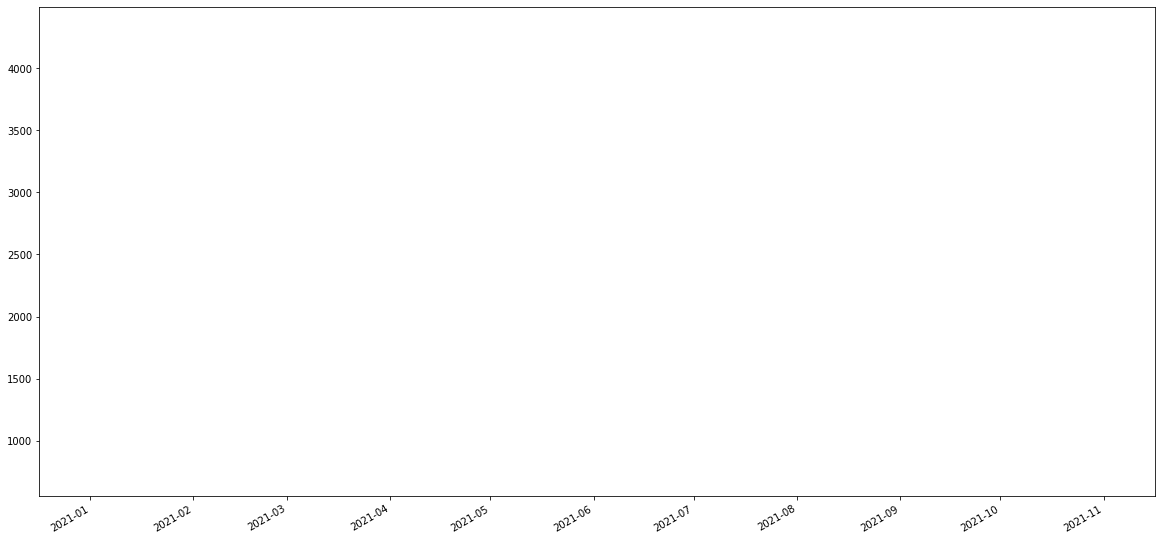

In [15]:
plt.figure(figsize=(20,10))
data.eth.plot()